In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pickle


In [ ]:
# Load the dataset
data = pd.read_csv('/content/test.csv')
print(data.shape)
print(data.head(10))

(1459, 81)
     Id    SalePrice  MSSubClass MSZoning  LotFrontage  LotArea Street Alley  \
0  1461  169277.0525          20       RH         80.0    11622   Pave   NaN   
1  1462  187758.3940          20       RL         81.0    14267   Pave   NaN   
2  1463  183583.6836          60       RL         74.0    13830   Pave   NaN   
3  1464  179317.4775          60       RL         78.0     9978   Pave   NaN   
4  1465  150730.0800         120       RL         43.0     5005   Pave   NaN   
5  1466  177150.9892          60       RL         75.0    10000   Pave   NaN   
6  1467  172070.6592          20       RL          NaN     7980   Pave   NaN   
7  1468  175110.9565          60       RL         63.0     8402   Pave   NaN   
8  1469  162011.6988          20       RL         85.0    10176   Pave   NaN   
9  1470  160726.2478          20       RL         70.0     8400   Pave   NaN   

  LotShape LandContour  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0      Reg         Lvl  ...   

In [ ]:
# Ensure 'SalePrice' column exists in data
if 'SalePrice' not in data.columns:
    raise ValueError("'SalePrice' column is missing from the data")

In [ ]:
# Select relevant features and target variable
features = ['Neighborhood', 'LotArea', 'YearBuilt', 'BldgType', 'CentralAir', 'GarageCars', 'TotRmsAbvGrd', 'FullBath', 'HalfBath']
target = 'SalePrice'

X = data[features]
y = data[target]

In [ ]:
# Preprocess features
categorical_features = ['Neighborhood', 'BldgType', 'CentralAir']
numerical_features = ['LotArea', 'YearBuilt', 'GarageCars', 'TotRmsAbvGrd', 'FullBath', 'HalfBath']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
# Fit the preprocessor on the entire data
preprocessor.fit(X)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['LotArea', 'YearBuilt', 'GarageCars',
                                  'TotRmsAbvGrd', 'FullBath', 'HalfBath']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Neighborhood', 'BldgType', 'CentralAir'])])

In [ ]:
# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LotArea', 'YearBuilt',
                                                   'GarageCars', 'TotRmsAbvGrd',
                                                   'FullBath', 'HalfBath']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Neighborhood', 'BldgType',
                                                   'CentralAir'])])),
                ('regressor', LinearRegression())])

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 65925885.49403548


In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

In [ ]:
# Calculate residuals
residuals = y_test - y_pred

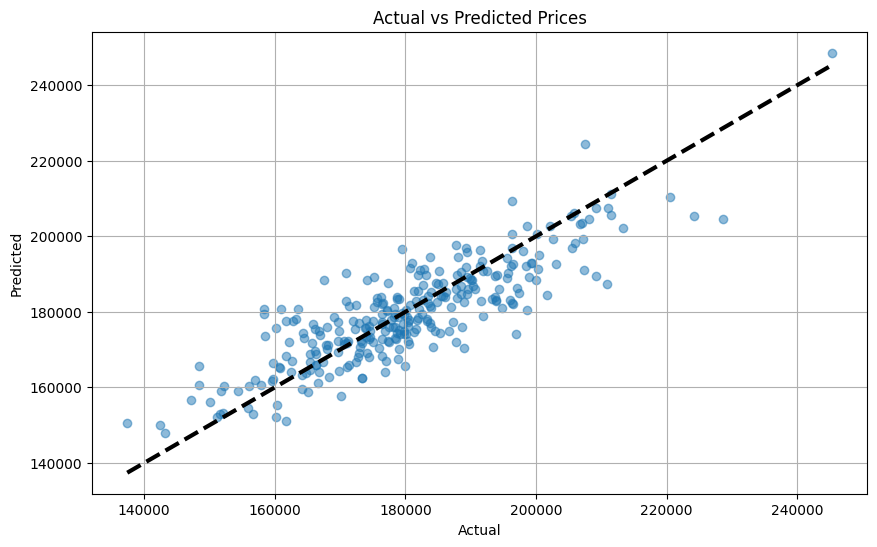

In [ ]:
# Scatter Plot of Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Prices')
plt.grid(True)
plt.savefig('actual_vs_predicted.png')  # Save the figure
plt.show()

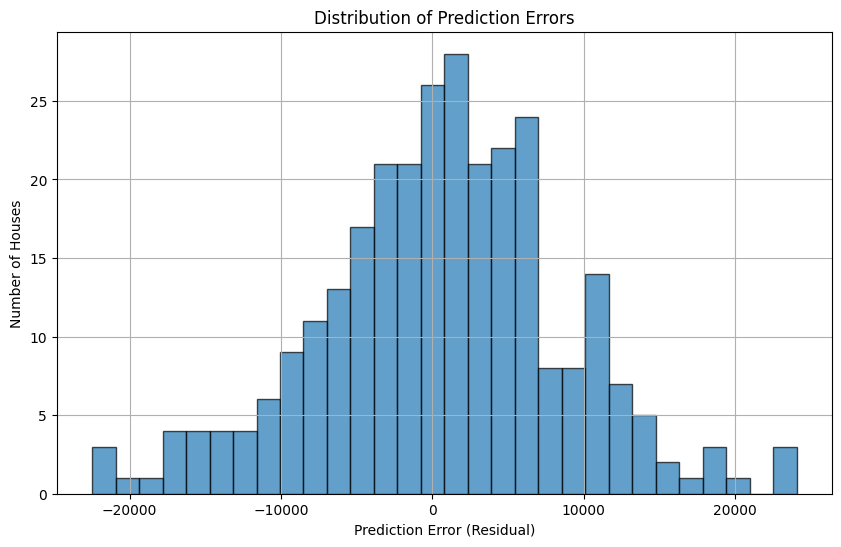

In [ ]:
# Histogram of Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Prediction Error (Residual)')
plt.ylabel('Number of Houses')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.savefig('histogram_of_residuals.png')
plt.show()

In [ ]:
# Print the first few predictions and actual values
for actual, predicted in zip(y_test[:10], y_pred[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")

Actual: 166374.8799, Predicted: 166004.8878579898
Actual: 184795.7837, Predicted: 182645.84303962308
Actual: 184199.7882, Predicted: 170796.8060590612
Actual: 156060.8538, Predicted: 160407.94943684523
Actual: 201691.2083, Predicted: 184470.26991914748
Actual: 186920.5126, Predicted: 181214.5531868635
Actual: 191719.1617, Predicted: 193331.3108423811
Actual: 179749.8762, Predicted: 179046.91573779628
Actual: 195560.883, Predicted: 189043.41940594642
Actual: 180085.7669, Predicted: 174043.1061903243


In [ ]:
# Save the model to a file
model_path = 'house_price_model.pkl'
with open(model_path, 'wb') as model_file:
    pickle.dump(model, model_file)


In [ ]:
# Save the preprocessor separately
with open('preprocessor.pkl', 'wb') as preprocessor_file:
    pickle.dump(preprocessor, preprocessor_file)